# Kernelized Neural Process

Last Update : 13 June 2019

In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = False # can also be set in the trainer

## Environment

In [2]:
cd ..

/master


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


## Dataset

In this notebook I only look at the periodic and mattern kernel. See [Tutorial 1 - Conditional Neural Process] for more details.

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

In [4]:
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, DotProduct, ConstantKernel
from ntbks_viz import plot_posterior_samples, plot_prior_samples, plot_dataset_samples

from ntbks_datasets import GPDataset

In [5]:
X_DIM = 1  # 1D spatial input
Y_DIM = 1  # 1D regression
N_POINTS = 128
N_SAMPLES = 100000 # this is a lot and can work with less

In [6]:
datasets = dict()
kwargs = dict(n_samples=N_SAMPLES, n_points=N_POINTS)
datasets["rbf"] = GPDataset(kernel=1.0 * RBF(length_scale=1.0,
                                             length_scale_bounds=(1e-1, 10.0)),
                            **kwargs)

datasets["periodic"] = GPDataset(kernel=1.0 * ExpSineSquared(length_scale=1.0,
                                                             periodicity=3.0,
                                                             length_scale_bounds=(0.1, 10.0),
                                                             periodicity_bounds=(1.0, 10.0)),
                                 **kwargs)
datasets["non-stationary"] = GPDataset(kernel=(ConstantKernel(0.1, (0.01, 10.0)) *
                                               (DotProduct(sigma_0=1.0,
                                                           sigma_0_bounds=(0.1, 10.0)) ** 2)),
                                       **kwargs)
datasets["matern"] = GPDataset(kernel=1.0 * Matern(length_scale=1.0,
                                                   length_scale_bounds=(1e-1, 10.0),
                                                   nu=1.5),
                               **kwargs)

## Model


In [7]:
from torch.distributions import Normal

from skssl.transformers import (NeuralProcessLoss, NeuralProcess, AttentiveNeuralProcess, 
                                SelfAttentionBlock, SinusoidalEncodings, FeatureEncodings)
from skssl.predefined import MLP, merge_flat_input, get_uninitialized_mlp
from skssl.transformers.neuralproc.datasplit import context_target_split

In [8]:
R_DIM = 128
RANGE_CNTXT = (4, 50)  # context points will be sampled uniformly in this range
RANGE_EXTRA_TRGTS = (3, N_POINTS-RANGE_CNTXT[1])  # extra number of targtes points 

In [9]:
def get_cntxt_trgt(*args):
    return context_target_split(*args, range_cntxts=RANGE_CNTXT, range_extra_trgts=RANGE_EXTRA_TRGTS)

def init_model():
    return AttentiveNeuralProcess(X_DIM, Y_DIM,
                         XEncoder=FeatureEncodings, 
                         XYEncoder=merge_flat_input(get_uninitialized_mlp(n_hidden_layers=2),
                                                    is_sum_merge=False),  
                         Decoder=merge_flat_input(get_uninitialized_mlp(n_hidden_layers=4),
                                                  is_sum_merge=False),  # no self attention encoder 
                         r_dim=R_DIM,
                         get_cntxt_trgt=get_cntxt_trgt,
                         aggregator=torch.mean,
                         PredictiveDistribution=Normal, 
                         LatentEncoder=MLP,
                         x_transf_dim=8,
                          attention="weighted_dist", # parameter free attention because simple task
                          encoded_path="both", # use both latent  and deterministic path as in paper
                         is_normalize=False)

In [10]:
# initialize one model for each dataset
data_models = {name: (init_model(), data) 
               for name, data in datasets.items()}

/master/skssl/predefined/mlp.py:56: UserWarning: hidden_size=32 smaller than output=256 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


### N Param

Number of parameters (note that I did not play around with this much, this depends a lot on the representation size):

In [11]:
from utils.helpers import count_parameters

In [12]:
for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break

N Param: 95765


The increase of parameters doesn't come from attention (as the attention is parameter free in this case), but from the fact that we have a deterministic and a latent path. Using only a deterministic path, the model can be very small. See the following notebook to see such a model with only 35682 parameters : [Small Multihead Conditional Attentive Neural Process]

[Small Multihead Conditional Attentive Neural Process]: Small%20Multihead%20Conditional%20Attentive%20Neural%20Process.ipynb

## Training

In [13]:
from skorch.callbacks import ProgressBar, Checkpoint

from skssl.training import NeuralNetTransformer
from skssl.training.helpers import make_Xy_input

Nota Bene: using a small batch size is probably important as we use fix amount of context in batch, and with attention you don't have aggregation => the number of context points changes the attention mechanism (the softmax) => use small to have many different number of context points but we want a fair comparison so keep `learning rate=1e-3` and `batch_size=64` like other notebook.

In [14]:
N_EPOCHS = 30 # 30 is enough
BATCH_SIZE = 64 
is_RETRAIN = True # if false load precomputed

In [15]:
for k,(neural_proc, dataset) in data_models.items():
    print()
    print("--- {} {} ---".format("Training" if is_RETRAIN else "Loading", k))
    print()
    
    chckpt = Checkpoint(dirname="results/notebooks/neural_process/knp_{}".format(k), 
                        monitor='train_loss_best') # train would be same as validation as always resamples
    
    model = NeuralNetTransformer(neural_proc, NeuralProcessLoss,
                                 max_epochs=N_EPOCHS,
                                 batch_size=BATCH_SIZE,
                                 train_split=None,  # don't use cross validation dev set
                                 lr=1e-3, # they use 5e-5 because 16 batch size but that would be slow
                                 callbacks=[ProgressBar(), 
                                            chckpt], # checkpoint best model
                                ) 
    
    if is_RETRAIN:
        _=model.fit(*make_Xy_input(dataset))
    
    # load in all case => even when training loads the best checkpoint
    model.initialize()
    model.load_params(checkpoint=chckpt)


--- Training rbf ---



  epoch    train_loss    cp      dur
-------  ------------  ----  -------
      1     5349.1450     +  28.3418


      2      727.3895     +  36.0466


      3      946.3741        35.6643


      4      183.2573     +  34.8442


      5      182.1560     +  35.0141


      6      181.9863     +  34.4802


      7      181.8808     +  34.7671


      8      181.8079     +  34.7610


      9      181.7570     +  34.7756


     10      181.7292     +  35.2416


     11      181.7045     +  35.6965


     12      181.6898     +  35.3702


     13      181.6851     +  35.9428


     14      181.6838     +  35.4351


     15      181.7017        34.5227


     16      181.6798     +  36.1200


     17      181.6764     +  33.7194


     18      181.6714     +  35.5014


     19      181.6691     +  35.8903


     20      181.6685     +  34.4481


     21      181.6651     +  35.0651


     22      181.6606     +  34.5240


     23      181.6606     +  35.8394


     24      181.6580     +  34.9118


     25      181.6574     +  36.0567


     26      181.6578        32.8788


     27      181.6701        35.9568


     28      181.6799        34.2662


     29      181.6569     +  35.3090


     30      181.6520     +  35.3381
Re-initializing optimizer because the following parameters were re-set: .

--- Training periodic ---



  epoch    train_loss    cp      dur
-------  ------------  ----  -------
      1     1355.2228     +  34.4198


      2      312.9880     +  34.0304


      3      155.4734     +  36.2204


      4      141.9795     +  34.6134


      5      139.3708     +  32.0352


      6      133.9902     +  29.8280


Re-initializing optimizer because the following parameters were re-set: .

--- Training non-stationary ---



Re-initializing optimizer because the following parameters were re-set: .

--- Training matern ---



Re-initializing optimizer because the following parameters were re-set: .


# Trained Prior

In [18]:
EXTRAP_DISTANCE = 2  # add 2 to the right for extrapolation
INTERPOLATION_RANGE = dataset.min_max
EXTRAPOLATION_RANGE = (dataset.min_max[0], dataset.min_max[1]+EXTRAP_DISTANCE )

std: 1.3859474551677702
std: 0.7437929022312165
std: 0.5138238655030728
std: 0.1696754863858222


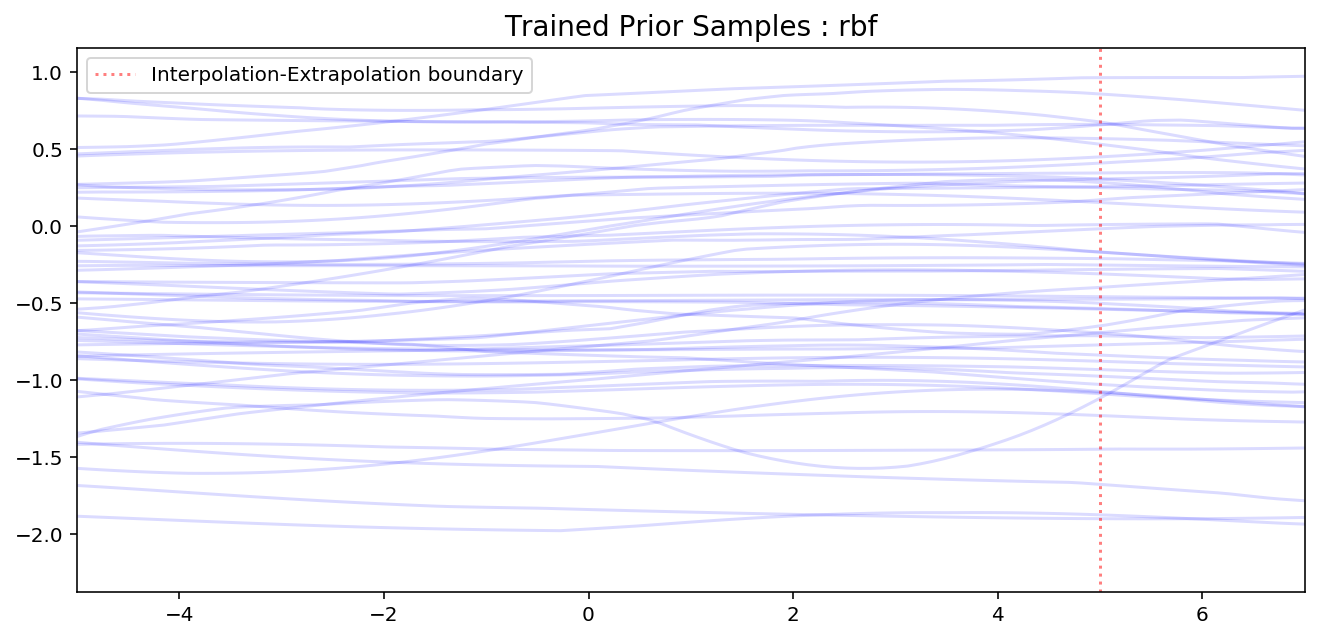

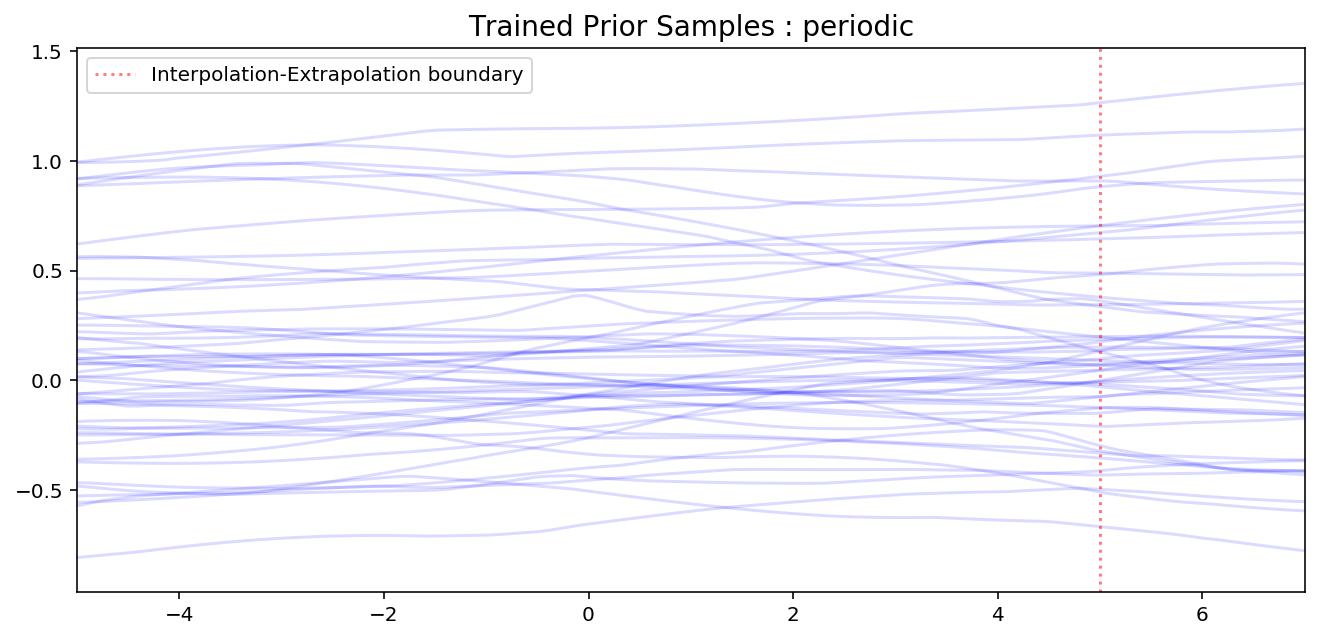

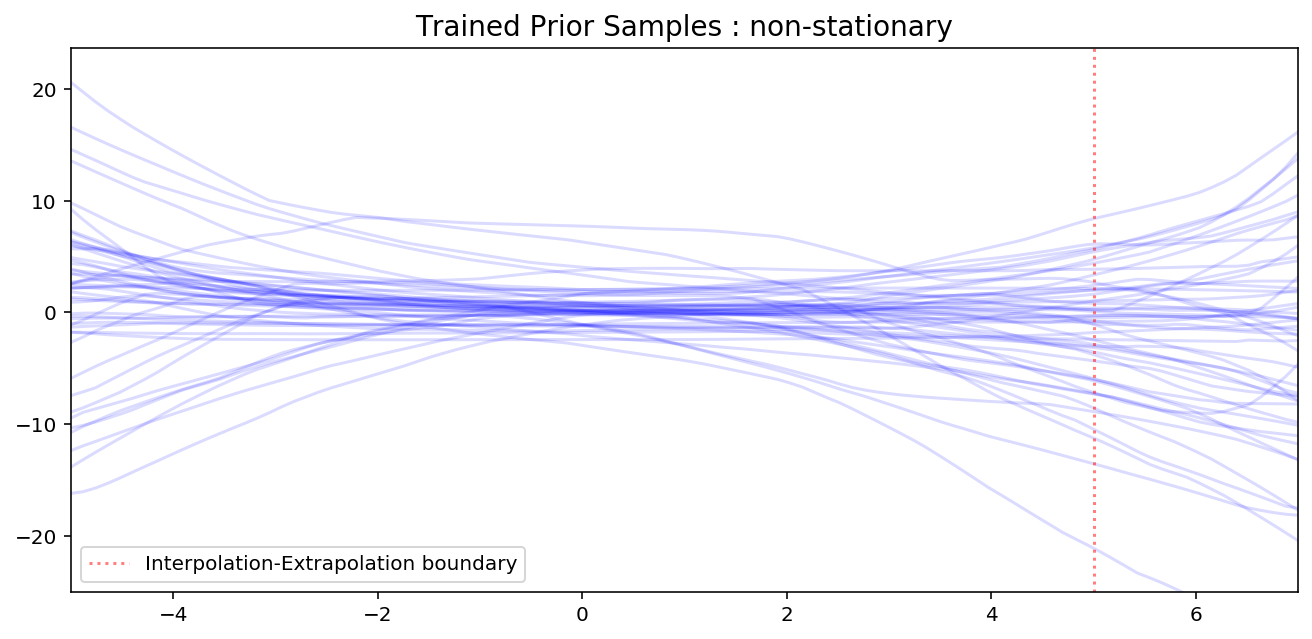

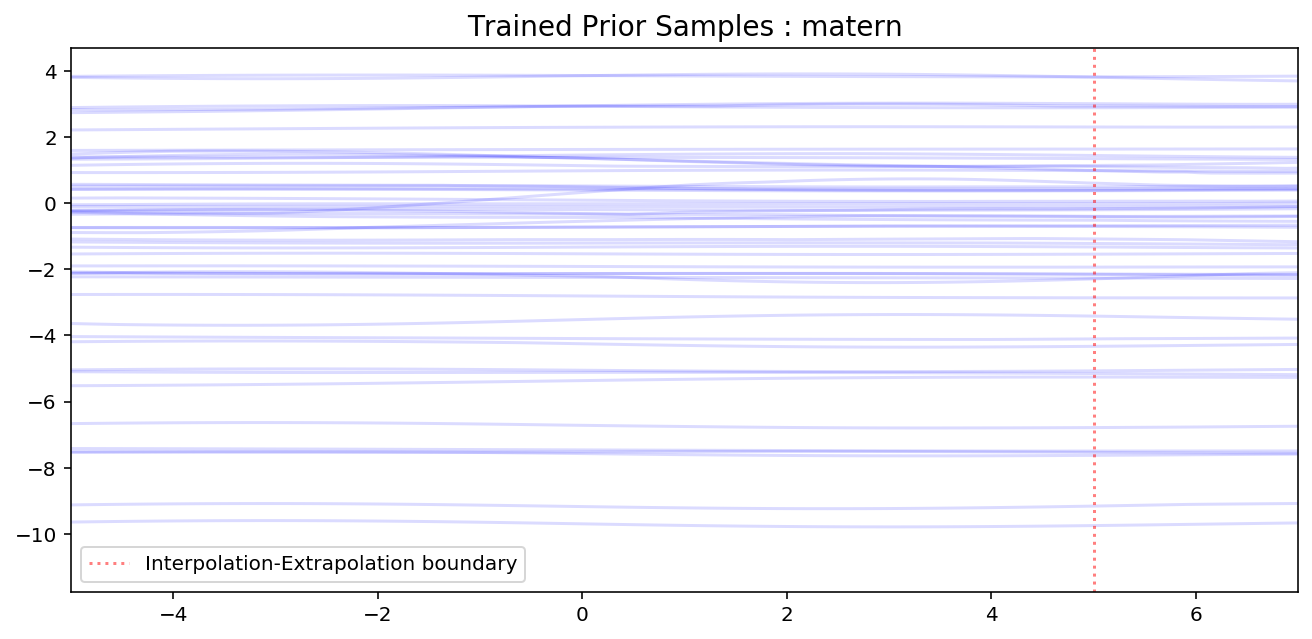

In [19]:
for k,(neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, 
                       title="Trained Prior Samples : {}".format(k), 
                       test_min_max=EXTRAPOLATION_RANGE, 
                       train_min_max=INTERPOLATION_RANGE)

# Posterior

std: 0.9966236948966979
std: 0.7557855308055879
std: 0.10000001639127731
std: 0.10000001639127731


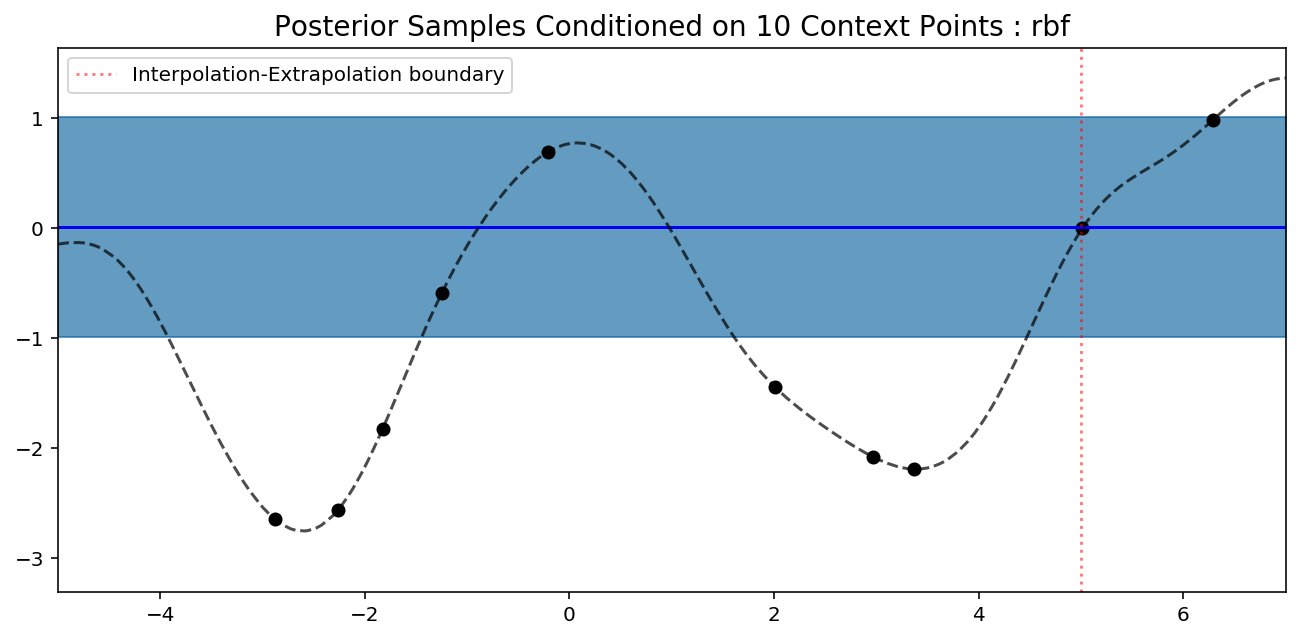

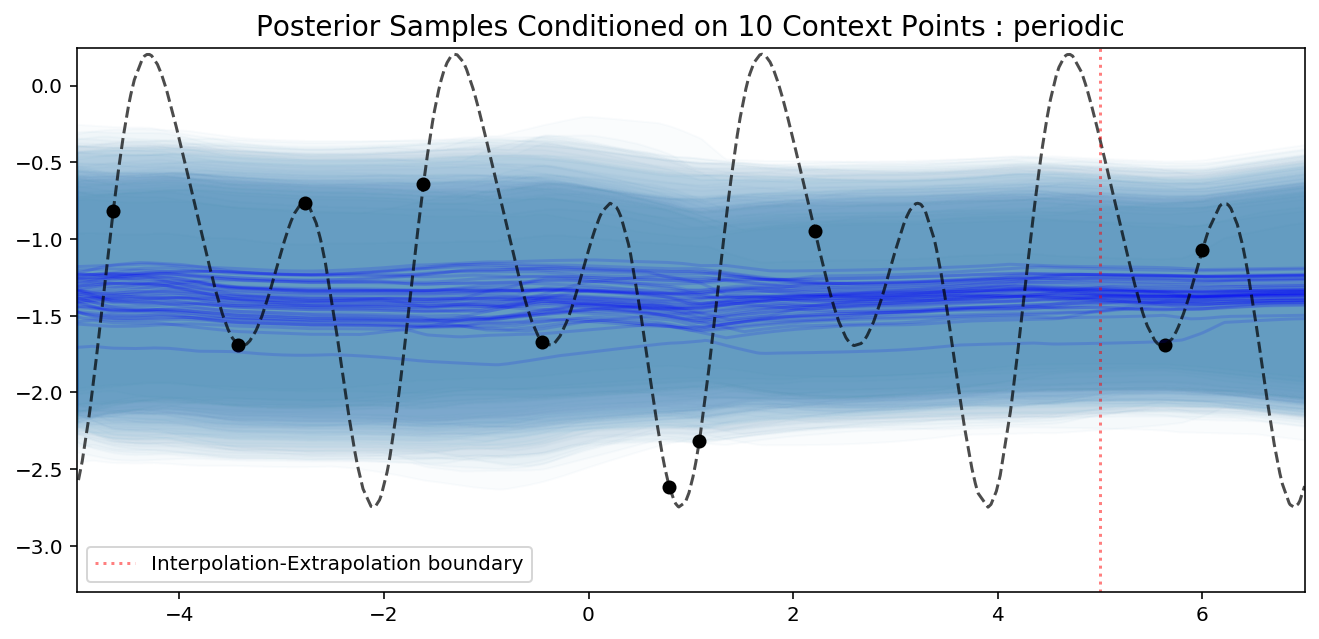

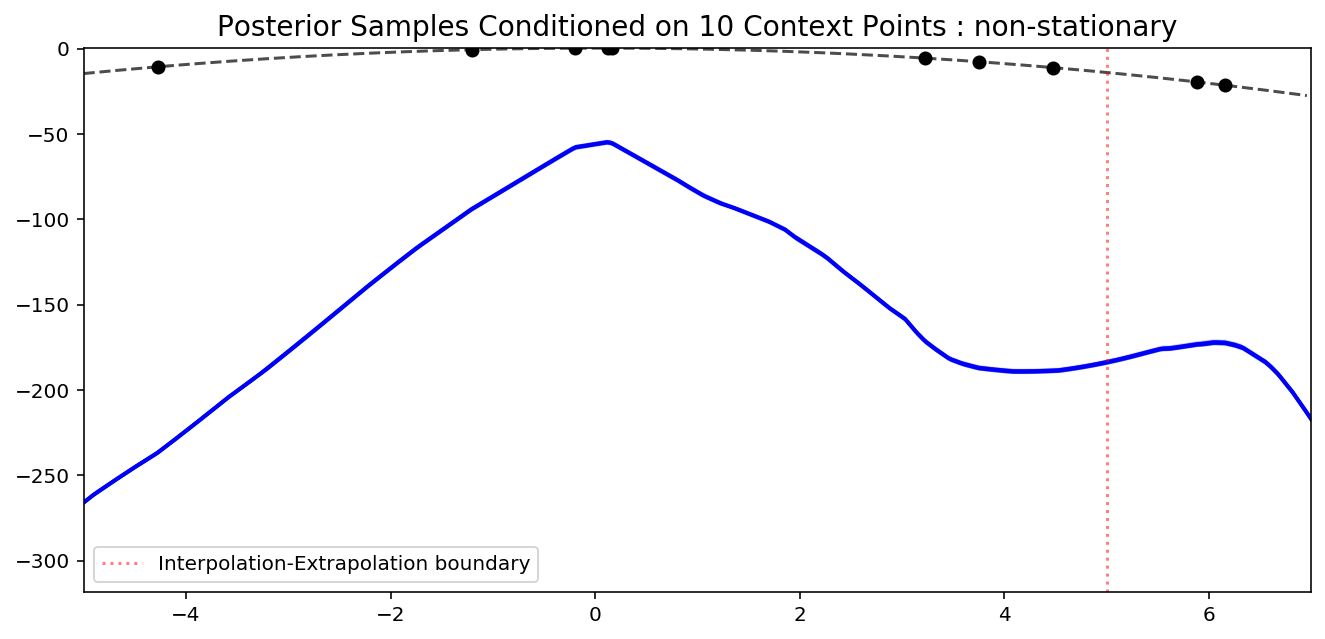

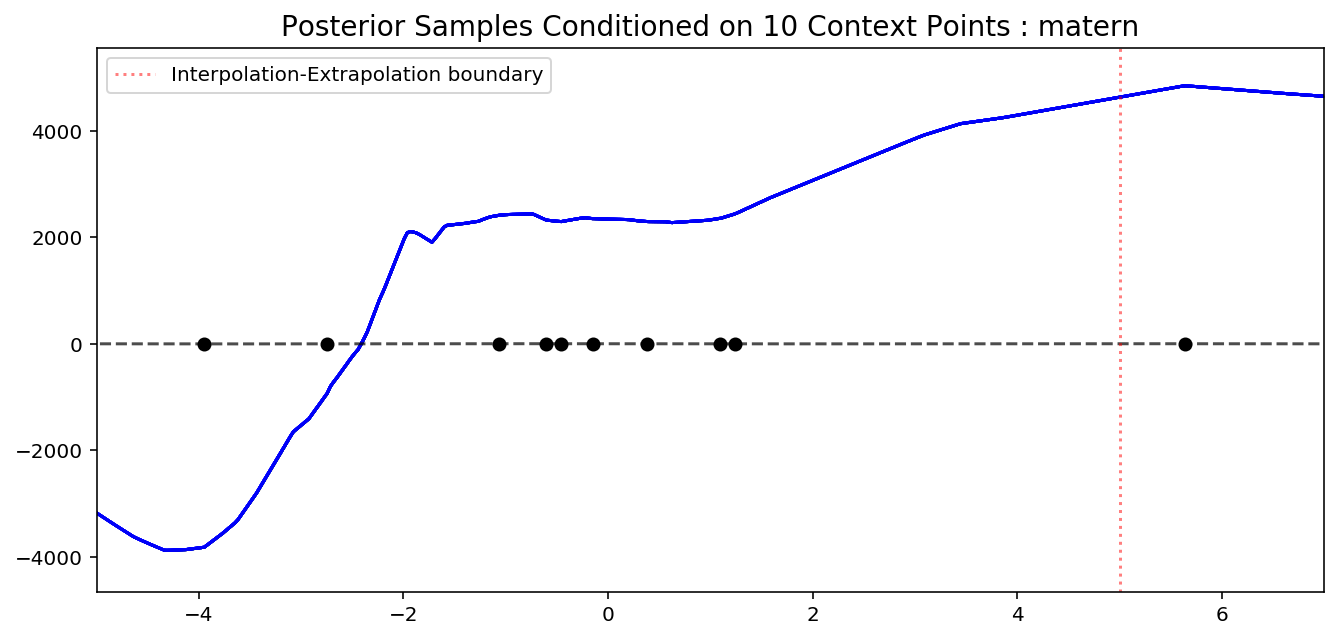

In [20]:
N_CNTXT = 10
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=400,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

In [ ]:
N_CNTXT = 2
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           n_samples=30,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

In [ ]:
N_CNTXT = 20
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

In [ ]:
N_CNTXT = 1
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

We see that the predictions are much better than in [Tutorial 2 - Neural Process]

**Good**:
- the sampled function all go through or close to the context points
- the uncertainty decreases close to context points
- the samples all seem relatively different (not linear shifts like in [Tutorial 2 - Neural Process])

**Bad**:
- there seems to always be a strange "jump" in the middle of region between 2 far points. This is probably due to the softmax in cross attention, and disappears when using multihead attention. 
- cannot extrapolate and not even give high uncertainty when extrapolating

[Tutorial 2 - Neural Process]: Tutorial%202%20-%20Neural%20Process.ipynb

In [27]:
class ReturnInput(nn.Module):
    def __init__(self, which_input):
        super().__init__()
        self.which_input = which_input
    
    def forward(self, *args):
        return args[self.which_input-1]

In [28]:
m = ReturnInput(2)

In [29]:
m(torch.tensor(1.), torch.tensor(1.))

tensor(1.)